In [299]:
import networkx as nx
import sys
import os
from termcolor import colored

In [300]:
methods_list = ['k_shell', 'CBIM', 'CIM', 'our_model_v02', 'MA_IMMULTI']
draw_network = False

In [301]:
CLASSES_PATH = os.path.dirname(os.path.abspath('D:/Masters thesis/Code/Classes/'))
if not (CLASSES_PATH in sys.path):
    sys.path.append(CLASSES_PATH)
from Classes.Files_Handler_Class import Files_Handler
from Classes.K_Shell_Calculate_Class import K_Shell_Calculate
from Classes.Resd_Network_Infos_Class import Resd_Network_Infos
from Classes.SIR_Diffusion_Model_Class import SIR_Diffusion_Model
from Classes.Get_Past_Results_Class import Get_Past_Results
from Classes.Network_Infos_Writer_Class import Network_Infos_Writer
from Classes.Layers_Ranking_Class_Old import Layers_Ranking
from Classes.Network_Node_Centrality_Class_Old import Network_Node_Centrality
from Classes.Bcolors_Class import Bcolors as bcolors
from Classes.CSV_Files_Class import CSV_Files

In [302]:
color_list = ["light_red", "light_green", "light_yellow",
               "light_blue","light_magenta", "light_cyan",
               "blue", "red", "white", "green", "yellow",
                 "magenta", "cyan", ]

In [303]:
files_handler_obj = Files_Handler()
file_path = files_handler_obj.select_files("text files", ".edgeslist .edgelist .edges .mtx .txt")
if file_path is None or file_path == '':
    sys.exit("File Selection Canceled !")
file_info = files_handler_obj.get_file_path_info(file_path)
network_name = file_info['name']
network_type = file_info['type']
network_path = file_info['path']
if network_name == "":
    sys.exit("Dont Network Selection!")
file_info


{'path': 'D:/Masters thesis/Methods For Compare/Datasets/01 - Sanremo2016_final (55897 Node and 3 Layer)/',
 'name': 'Sanremo2016_final',
 'type': '.edgeslist'}

In [304]:
compares_path = files_handler_obj.make_dir(file_info['path'], 'Compare_Methods')

In [305]:
resd_network_infos_object = Resd_Network_Infos()
(
    network_layers_info,
    network_layers_nodes,
    entra_layer_edges,
    entra_layer_edges_features,
    inter_layer_edge,
) = Resd_Network_Infos.read_nodeFrom_layerFrom_nodeTo_layerTo(
    network_path, network_name, network_type
)


In [306]:
print(file_info['name'], '\n')
sum_of_layers_nodes = 0
network_layers_count = len(network_layers_info)
graphs_of_network = [None] * network_layers_count
network_entier_edges = ""
layers_nodes_infect_scale = []

i = 0
j = 0
while i < network_layers_count:
    graphs_of_network[i] = nx.Graph()
    network_layers_nodes[i] = list(set(network_layers_nodes[i]))
    layers_nodes_infect_scale.append({})
    if len(network_layers_nodes[i]) > 0:
        # graphs_of_network[i].add_nodes_from(network_layers_nodes[i])
        graphs_of_network[i].add_edges_from(entra_layer_edges[i])
        nx.set_node_attributes(graphs_of_network[i], None, 'community')

        graphs_of_network[i].graph["id"] = i
        graphs_of_network[i].graph["node_num"] = graphs_of_network[i].number_of_nodes()
        graphs_of_network[i].graph["edge_num"] = graphs_of_network[i].number_of_edges()

        print(colored("Layer "  + str(i) + ": " + str(graphs_of_network[i].number_of_nodes()) + " Node And " +
                       str(graphs_of_network[i].number_of_edges()) + " Edge", color_list[j]))
        # print(colored(graphs_of_network[i].graph['k_shell_info'], color_list[i]))
    i += 1
    j += 1
    if j >= len(color_list):
        j = 0

network_entier_nodes_list = []
for item in network_layers_nodes:
    network_entier_nodes_list += item
    sum_of_layers_nodes += len(item)

network_entier_nodes_list = list(set(network_entier_nodes_list))
network_entier_nodes_count = len(network_entier_nodes_list)
print()
print("network entier nodes : " + colored(str(network_entier_nodes_count), "yellow"))

Sanremo2016_final 

Layer 1: 49904 Node And 210308 Edge
Layer 2: 34564 Node And 92970 Edge
Layer 3: 9461 Node And 11253 Edge

network entier nodes : 55897


In [307]:
import json
import re
import math

def load_results_from_file(root_path:os.path, method_title):
    files_handler_obj = Files_Handler()
    root_path = root_path + method_title + '/'
    files_list = files_handler_obj.get_files_in_path(root_path)
    # print(files_list)
    infection_result_files = []
    regex1 = r"^infection k="
    regex2 = r".json$"
    for item in files_list:
        if re.findall(regex1, item) and re.findall(regex2, item):
            infection_result_files.append(item)
    load_flag = False
    info = {}
    for item in infection_result_files:
        k = item.split(" ")[1].split("=")[-1]
        try:
            with open(root_path + item, 'r') as openfile:
                info[k] = json.load(openfile)
            load_flag = True
        except:
            pass
    if len(info.keys()) <= 0:
        info = None
    return info, method_title, load_flag

def get_seedset_degree_list(graphs_of_network, seedset):
    node_degree_list = []
    sum_of_degrees = 0
    node_existence_counter = 0
    layer_counter = 0
    for node in seedset:
        node_degree_list.append([])
        layer_counter = 0
        for j, graph in enumerate(graphs_of_network):
            if graph.number_of_nodes() > 0 and node in graph:
                layer_counter += 1
                node_degree = graph.degree(node)
                sum_of_degrees += node_degree
                node_existence_counter += 1
                node_degree_list[-1].append(node_degree)
            elif graph.number_of_nodes() > 0:
                layer_counter += 1
    degree_avg = sum_of_degrees / node_existence_counter
    layer_participation = node_existence_counter / (len(seedset) * layer_counter)
    return node_degree_list, degree_avg, layer_participation

def get_distance_seedset_nodes_each_other(graphs_of_network, seedset):
    sum_of_distance = 0
    counter = 0
    
    if len(seedset) < 2:
        return 0

    for graph in graphs_of_network:
        i = 0
        while i < len(seedset):
            j = i + 1
            while j < len(seedset):
                if graph.number_of_edges() > 0:
                    if seedset[i] in graph and seedset[j] in graph:
                        try:
                            dist = nx.shortest_path_length(graph, source=seedset[i], target=seedset[j])
                        except:
                            dist = 6
                        sum_of_distance += dist
                        counter += 1
                    else:
                        sum_of_distance += 6
                        counter += 1
                j += 1
            i += 1

    return (sum_of_distance/counter)

def get_seedset_similarity(r1, r2):
    similarity = 0
    for item in r1 :
        if item in r2:
            similarity += 1
    return (similarity / len(r1))

def results_annalise (graphs_of_network, results, other_results):
    results_annalise_info = {}
    if not(results is None):
        for k, v in results.items():
            results_annalise_info[k] = {}
            (
                results_annalise_info[k]["seedset_degree_list"],
                results_annalise_info[k]["seedset_degree_average"],
                results_annalise_info[k]["seedset_layer_participation"],
            ) = get_seedset_degree_list(graphs_of_network, v['seed_set'])
            
            similarity = 0
            temp_similarity = 0
            for result in other_results:
                if not (result is None):
                    temp_similarity += get_seedset_similarity(v['seed_set'], result[k]['seed_set'])
            similarity += (temp_similarity / len(other_results))

            results_annalise_info[k]["seedset_similarity"] = similarity

            results_annalise_info[k]["seedset_distance_average"] = get_distance_seedset_nodes_each_other(graphs_of_network, v['seed_set'])
    return results_annalise_info



In [308]:
methods_results = {}
for item in methods_list:
    method_results, method_title, method_results_flag = load_results_from_file(file_info['path'], item)
    if method_results_flag:
        methods_results[item] = {}
        methods_results[item]['results'] = method_results
        methods_results[item]['title'] = method_title
        methods_results[item]['status'] = method_results_flag

In [309]:
for method, results in methods_results.items():
    other_method_results = []
    print(method)
    for t_method, t_results in methods_results.items():
        if t_method != method:
            other_method_results.append(t_results['results'])
    methods_results[method]['results_annalise'] = results_annalise(graphs_of_network, results['results'], other_method_results)

k_shell
CBIM
CIM
our_model_v02


In [310]:
k_values = list(methods_results[methods_list[0]]['results'].keys())
k_values = [int(k) for k in k_values]
k_values = sorted(k_values)
k_values

[1, 4, 8, 12, 16, 20, 24, 28]

In [311]:
plt_color_list = ['green', 'cyan', 'blue', 'red', 'orange', 'black', 'brown', 'gold', 'yellow', 'magenta',
                        'lime', 'pink', 'gray', 'purple', 'silver']
plt_marker_list = ["o", "d", "s", "*", 'P', "2", "p", "v",
                        "X", "8", ".", '^', "<", "<", "+", ]

# plt_color_list = ['green', 'cyan', 'red', 'orange', 'black', 'brown', 'gold', 'yellow', 'magenta',
#                         'lime', 'pink', 'gray', 'purple', 'silver']
# plt_marker_list = ["o", "d", "*", 'P', "2", "p", "v",
#                         "X", "8", ".", '^', "<", "<", "+", ]

# plt_color_list = ['green', 'blue', 'red', 'orange', 'black', 'brown', 'gold', 'yellow', 'magenta',
#                         'lime', 'pink', 'gray', 'purple', 'silver', 'cyan']
# plt_marker_list = ["o", "s", "*", 'P', "2", "p", "v",
#                         "X", "8", ".", '^', "<", "<", "+","d"]

In [312]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def plot_line(plt, infection_scale, k_values, method_results, label, color, marker):
    results_infection = []
    for k in k_values:
        results_infection.append(method_results[str(k)][infection_scale])
    plt.plot(k_values, results_infection, label=label, linestyle='solid', marker=marker,  color=color)

def plot_lines(plt,compartion_parameter, infection_scale, k_values, method_results,
                method_results_annalise, color, marker, visable_infection:bool=False):
    results_degree_average = []
    results_infection = []
    for k in k_values:
        results_degree_average.append(method_results_annalise[str(k)][compartion_parameter])
        results_infection.append(method_results[str(k)][infection_scale])
    plt.plot(k_values, results_degree_average, linestyle='dashed', marker=marker,  color=color)
    if visable_infection:
        plt.plot(k_values, results_infection, linestyle='solid', marker=marker,  color=color)

def plot_comparison(compartion_parameter,infection_scale, k_values,
                    compartion_label, infection_label,
                    x_axis_lable, diagram_title,
                    list_of_results,
                    list_of_titles,
                    list_of_results_annalise,
                    plt_color_list,
                    plt_marker_list,
                    save_result_path,
                    legend_loc:str='best', visable_infection:bool=False):
    # fig = plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xticks(k_values)
    handles, labels = plt.gca().get_legend_handles_labels()
    i = 0
    for j, results in enumerate(list_of_results):
        if i >= len(plt_color_list) - 1:
            i = 0
        plot_lines(plt,compartion_parameter,infection_scale, k_values, results,
                    list_of_results_annalise[j], plt_color_list[i],plt_marker_list[i], visable_infection)
        handles.append(Line2D([0], [0], label=list_of_titles[j], color=plt_color_list[i], linestyle='', marker=plt_marker_list[i]))
        i += 1

    if visable_infection:
        handles.append(Line2D([0], [0], label=infection_label, color='black', linestyle='solid'))
        handles.append(Line2D([0], [0], label=compartion_label, color='black', linestyle='dashed'))

    plt.xlabel(x_axis_lable)
    plt.ylabel(compartion_label)
    # plt.title(diagram_title)
    plt.legend(handles=handles, loc=legend_loc, fontsize= 'small')

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    # plt.margins(0,0)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    plt.show()
    fig.savefig(save_result_path + diagram_title + '.png', bbox_inches='tight', pad_inches = 0.05)

def plot_infection_comparison(infection_scale, k_values,
                              infection_label, x_axis_lable, diagram_title,
                              list_of_results, list_of_titles,
                              plt_color_list, plt_marker_list,
                              save_result_path,
                              legend_loc='best'):
    # fig = plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xticks(k_values)
    i = 0
    for j, results in enumerate(list_of_results):
        if i >= len(plt_color_list) - 1:
            i = 0
        plot_line(plt,infection_scale, k_values, results, list_of_titles[j], plt_color_list[i], plt_marker_list[i])
        i += 1

    # plt.subplots_adjust(bottom=.2, left=.2)
    plt.xlabel(x_axis_lable)
    plt.ylabel(infection_label)
    # plt.title(diagram_title)
    plt.legend(loc=legend_loc)

    # plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    # plt.margins(0,0)
    # plt.gca().xaxis.set_major_locator(plt.NullLocator())
    # plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.show()
    fig.savefig(save_result_path + diagram_title + '.png', bbox_inches='tight', pad_inches = 0.05)

In [313]:
list_of_results = []
list_of_titles = []
list_of_results_annalise = []
for method, results in methods_results.items():
    list_of_results.append(results['results'])    
    list_of_titles.append(results['title'])
    list_of_results_annalise.append(results['results_annalise'])

file_info['name']

'Sanremo2016_final'

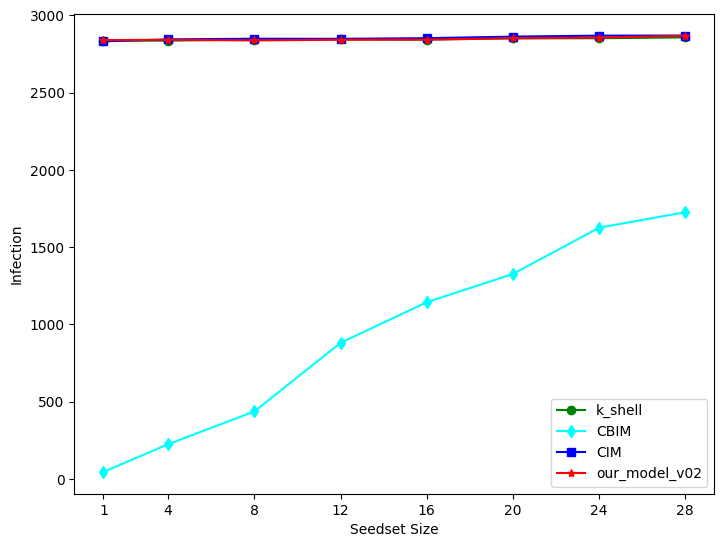

In [314]:
plot_infection_comparison(
    'infection', k_values,
    'Infection', 'Seedset Size',
    'Infection Node Comparison',
    list_of_results,
    list_of_titles,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

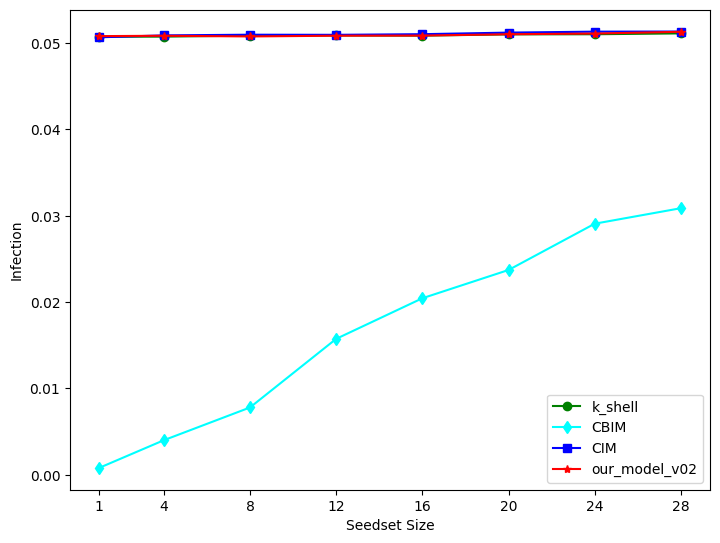

In [315]:
plot_infection_comparison(
    'percentage', k_values,
    'Infection', 'Seedset Size',
    'Infection Percentage Comparison',
    list_of_results,
    list_of_titles,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

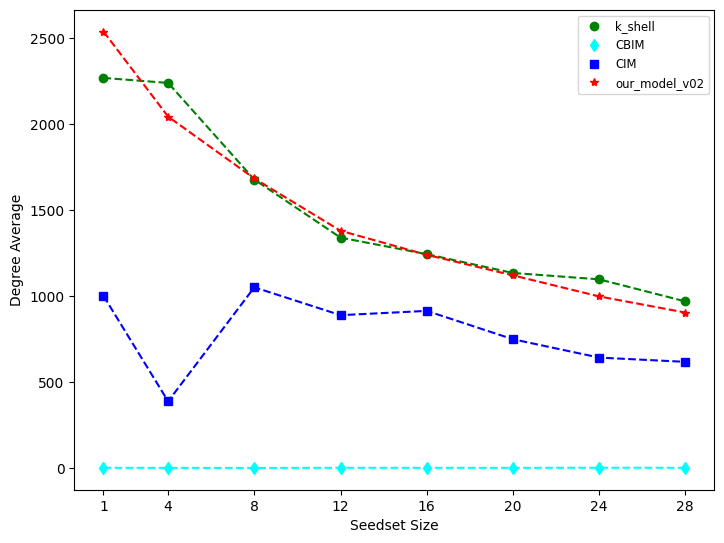

In [316]:
plot_comparison(
    "seedset_degree_average", 'infection', k_values,
    'Degree Average','Infection', 'Seedset Size',
    'Degree Average Comparison',
    list_of_results,
    list_of_titles,
    list_of_results_annalise,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

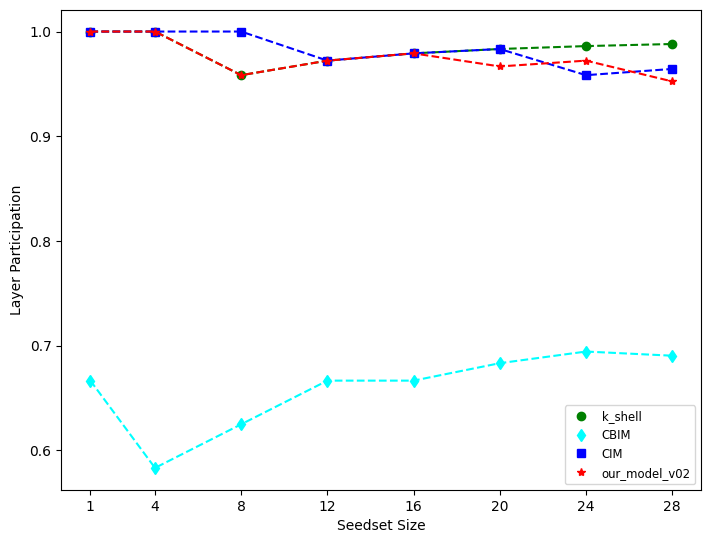

In [317]:
plot_comparison(
    "seedset_layer_participation", 'percentage', k_values,
    'Layer Participation','Infection Percentage','Seedset Size',
    'Layer Participation Comparison',
    list_of_results,
    list_of_titles,
    list_of_results_annalise,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

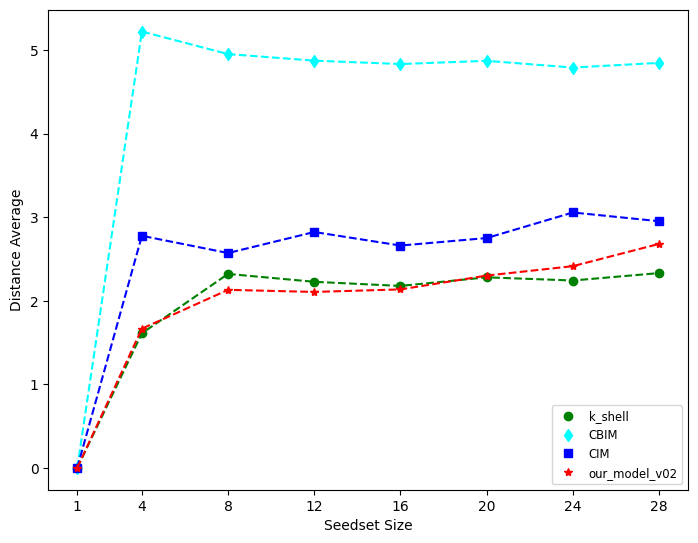

In [318]:
plot_comparison(
    "seedset_distance_average", 'percentage', k_values,
    'Distance Average','Infection Percentage','Seedset Size',
    'Distance Average Comparison',
    list_of_results,
    list_of_titles,
    list_of_results_annalise,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

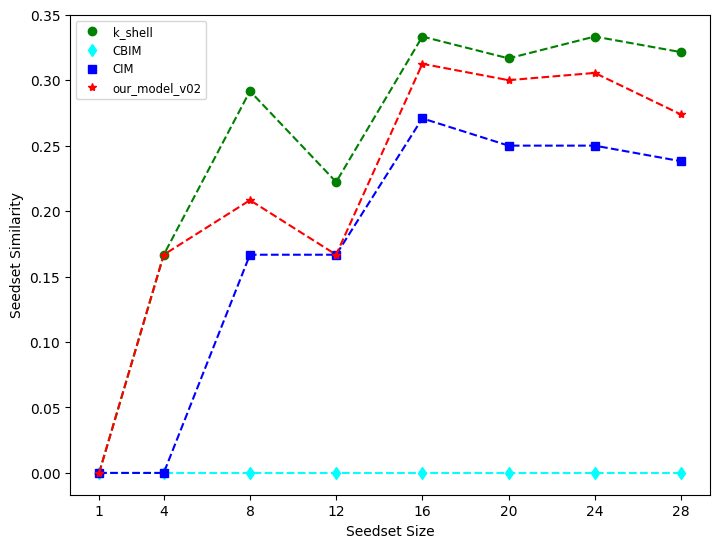

In [319]:
plot_comparison(
    "seedset_similarity", 'percentage', k_values,
    'Seedset Similarity','Infection', 'Seedset Size',
    'Seedset Similarity Comparison',
    list_of_results,
    list_of_titles,
    list_of_results_annalise,
    plt_color_list, plt_marker_list,
    compares_path,
    'best'
)

In [320]:
import networkx as nx
import plotly.graph_objects as go
def colorize_seedset_on_network(graphs_of_network, seedset, save_path, fig_title):
    for graph in graphs_of_network:
        if graph.number_of_nodes() > 0:   
            # Step 2: Generate 2D node positions
            pos = nx.spring_layout(graph)  # Spring layout for 2D positions

            # Extract node positions
            x_nodes = [pos[i][0] for i in graph.nodes()]  # x-coordinates of nodes
            y_nodes = [pos[i][1] for i in graph.nodes()]  # y-coordinates of nodes

            # Generate edge positions
            x_edges = []
            y_edges = []
            for edge in graph.edges():
                x_edges.extend([pos[edge[0]][0], pos[edge[1]][0], None])  # x-coordinates
                y_edges.extend([pos[edge[0]][1], pos[edge[1]][1], None])  # y-coordinates
            
            node_colors = []
            for node in graph.nodes():
                if node in seedset:
                    node_colors.append('red')
                else:
                    node_colors.append('yellow')

            # Step 3: Create Plotly figure
            fig = go.Figure()

            # Add edges
            fig.add_trace(go.Scatter(
                x=x_edges,
                y=y_edges,
                mode='lines',
                line=dict(color='blue', width=1),
                hoverinfo='none'
            ))

            # Add nodes
            fig.add_trace(go.Scatter(
                x=x_nodes,
                y=y_nodes,
                mode='markers+text',
                marker=dict(symbol='circle',
                            size=20, 
                            color=node_colors # Use the custom color list
                                ),
                text=[str(node) for node in graph.nodes()],  # Node labels
                textposition="middle center",
                hoverinfo='text',
            ))

            # Step 4: Customize layout
            fig.update_layout(
                title=fig_title + f" layer {graph.graph['id']}",
                showlegend=False,
                margin=dict(l=0, r=0, t=50, b=0),
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False),
                plot_bgcolor='white',
            )

            # Show the figure
            fig.show()
            fig.write_image(save_path + fig_title + f" layer {graph.graph['id']}.png")


In [321]:
try:
    for k, v in methods_results[methods_list[-1]]['results'].items():
        print(v['seed_set'])
except:
    draw_network = False

In [322]:
if draw_network:
    for k, v in methods_results[methods_list[-1]]['results'].items():
        colorize_seedset_on_network(graphs_of_network, v['seed_set'], compares_path, f"method {methods_results[methods_list[-1]]['title']} seedset size {k}")